In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sys
from tqdm.notebook import tqdm

sys.path.append('..')
from utils import *

In [3]:
data_path = '../__data__/Mary-Anesthesia-20160809-01.mat'
f = h5py.File(data_path, 'r')

In [4]:
test_duration = get_test_duration(f)
ain_index = get_analog_chnl_names(f)
ain_index

['reward',
 'eyePosX',
 'eyePosY',
 'pupilSize',
 'drugInfusion',
 'bar',
 'audio',
 'airPuff',
 'EEG',
 'EMG',
 'EEGbipolar',
 'cereStim',
 'SpO2',
 'heartRate',
 'cereStim_PPCSTG']

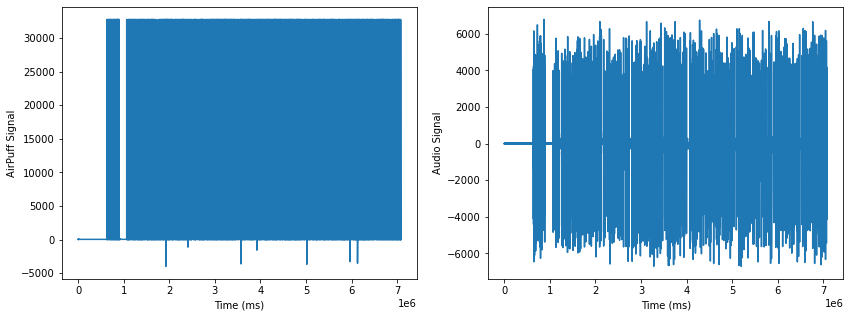

In [5]:
airPuff = get_analog_chnl('airPuff', f)
audio = get_analog_chnl('audio', f)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(airPuff)
plt.xlabel('Time (ms)')
plt.ylabel('AirPuff Signal')

plt.subplot(1, 2, 2)
plt.plot(audio)
plt.xlabel('Time (ms)')
plt.ylabel('Audio Signal')

plt.show()

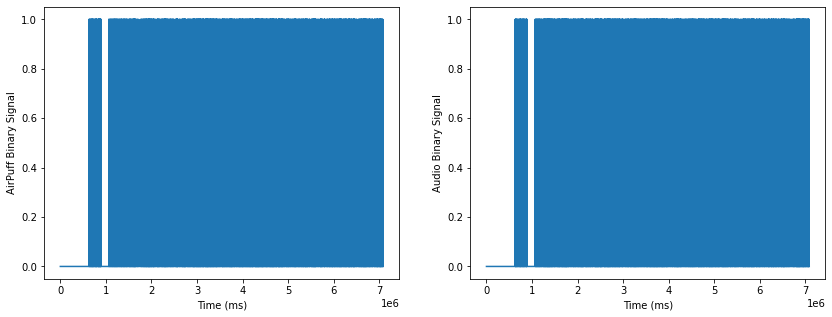

In [6]:
airPuff_binary, audio_binary = get_binary_signals(f)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(airPuff_binary)
plt.xlabel('Time (ms)')
plt.ylabel('AirPuff Binary Signal')

plt.subplot(1, 2, 2)
plt.plot(audio_binary)
plt.xlabel('Time (ms)')
plt.ylabel('Audio Binary Signal')
np
plt.show()

In [7]:
get_unit_spikes(234, f)

{'spike_times': array([1.29003333e+00, 1.55423333e+00, 2.18333333e+00, ...,
        7.08369487e+03, 7.08389350e+03, 7.08390390e+03]),
 'area': '7b',
 'hemisphere': 'right'}

## Spike Triggered Averaging

In [8]:
sta_length = 300
stimulus = airPuff_binary
stimulus_name = 'AirPuff Binary'
# stimulus = audio

phase_ranges = get_phase_ranges(f)
num_units = get_num_units(f)
iterator = tqdm(total = num_units*len(phase_ranges))

stas = []
for unit_index in range(num_units):
    stas.append({})
    unit_spikes = get_unit_spikes(unit_index, f)
    stas[-1]['area'] = unit_spikes['area']
    stas[-1]['hemisphere'] = unit_spikes['hemisphere']
    stas[-1]['stas'] = {}
    for phase in phase_ranges.keys():
        stas[-1]['stas'][phase] = {}
        stas[-1]['stas'][phase]['sta'], stas[-1]['stas'][phase]['num_spikes']  = get_spike_triggered_average(unit_spikes['spike_times'], stimulus, sta_length, get_sample_interval(f), phase_ranges[phase])
        iterator.update()

iterator.close()

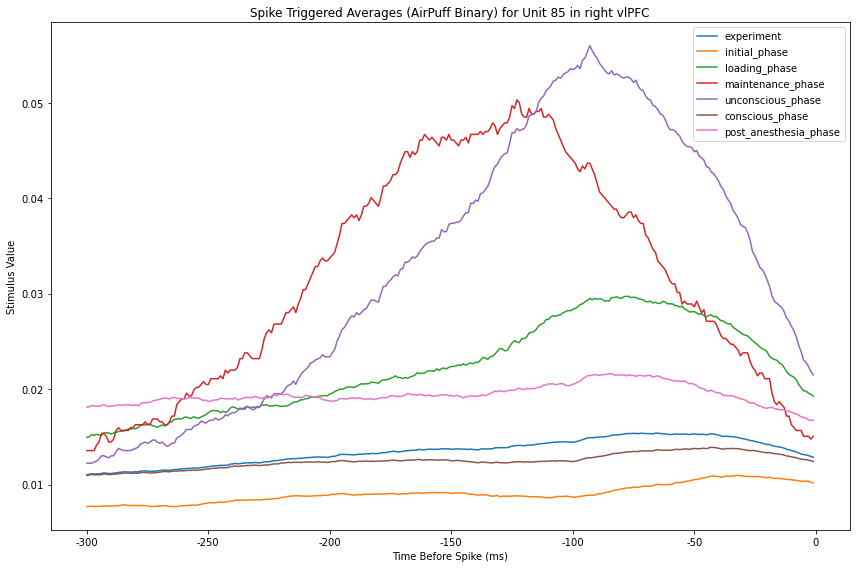

In [478]:
plt.figure(figsize=(12, 8))

unit_index = 85
for i, phase in enumerate(stas[unit_index]['stas'].keys()):
#     plt.subplot(3, 2, i+1)
    plt.plot(stas[unit_index]['stas'][phase]['sta'], label=phase)
plt.xlabel('Time Before Spike (ms)')
plt.xticks(np.arange(0, sta_length + 1, 50), np.arange(-sta_length, 1, 50))
plt.ylabel('Stimulus Value')
plt.title(f"Spike Triggered Averages ({stimulus_name}) for Unit {unit_index} in {stas[unit_index]['hemisphere']} {stas[unit_index]['area']}")
plt.legend()
plt.tight_layout()
plt.show()

### Averaging Across Areas

In [466]:
areas = ['vlPFC', 'FEF', 'CPB', '7b']

area_stas = {}
for area in areas:
    area_stas[area] = {}
    for phase in phase_ranges.keys():
        area_stas[area][phase] = dict(
            sta=np.zeros(sta_length),
            num_spikes=0
        )
    for unit_sta in stas:
        if unit_sta['area'] == area:
            for phase in unit_sta['stas'].keys():
                area_stas[area][phase]['sta'] += unit_sta['stas'][phase]['sta']*unit_sta['stas'][phase]['num_spikes']
                area_stas[area][phase]['num_spikes'] += unit_sta['stas'][phase]['num_spikes']
    
    for phase in phase_ranges.keys():
        area_stas[area][phase]['sta'] /= area_stas[area][phase]['num_spikes']

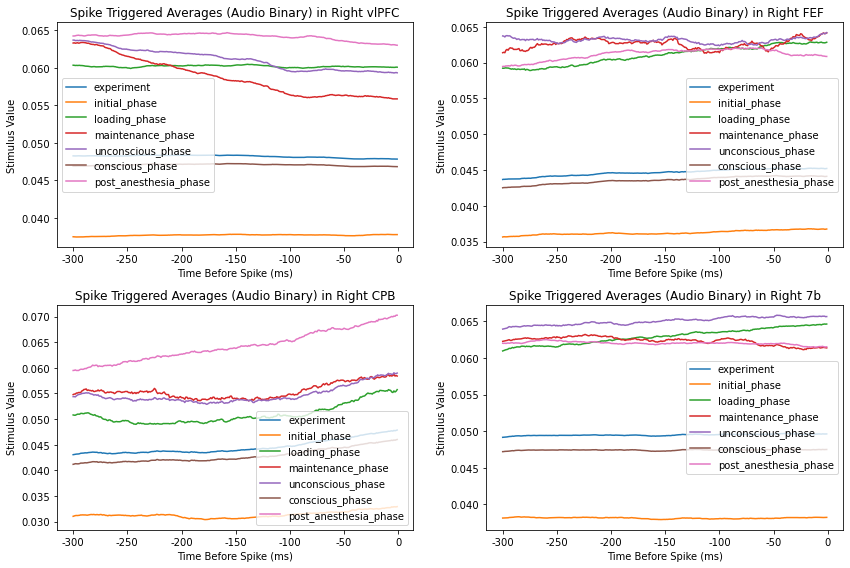

In [467]:
plt.figure(figsize=(12, 8))

unit_index = 0
for i, area in enumerate(areas):
    plt.subplot(2, 2, i+1)
    for phase in area_stas[area].keys():
        plt.plot(area_stas[area][phase]['sta'], label=phase)
    plt.xlabel('Time Before Spike (ms)')
    plt.xticks(np.arange(0, sta_length + 1, 50), np.arange(-sta_length, 1, 50))
    plt.ylabel('Stimulus Value')
    plt.title(f"Spike Triggered Averages ({stimulus_name}) in Right {area}")
    plt.legend()
plt.tight_layout()
plt.show()

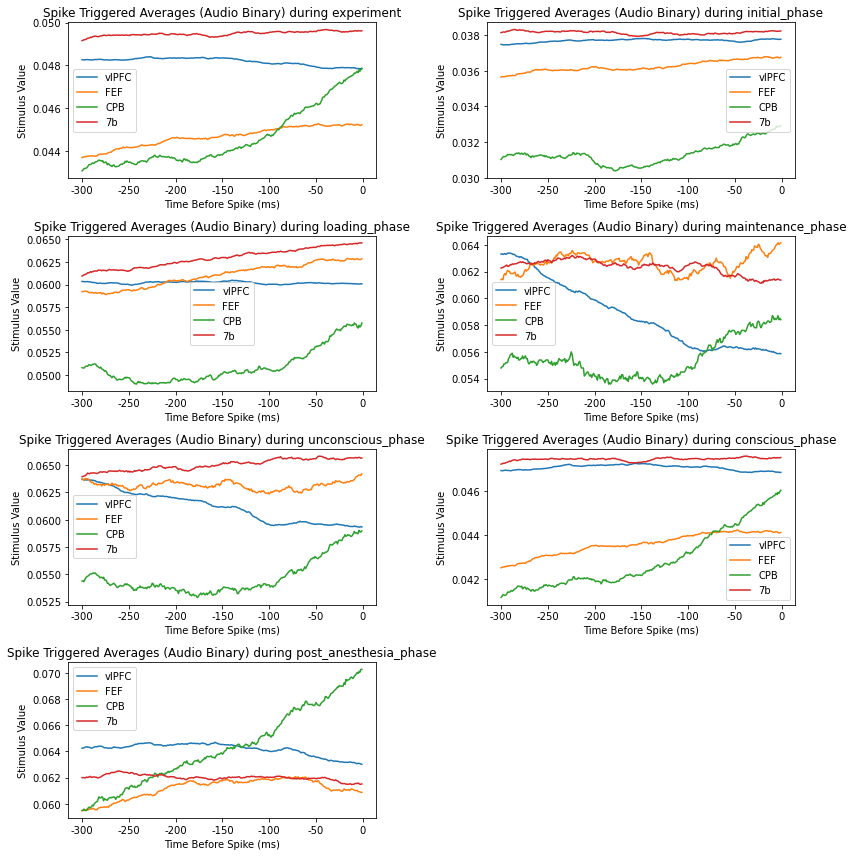

In [468]:
plt.figure(figsize=(12, 12))

unit_index = 0
for i, phase in enumerate(stas[unit_index]['stas'].keys()):
    plt.subplot(4, 2, i+1)
    for area in areas:
        plt.plot(area_stas[area][phase]['sta'], label=area)
    plt.xlabel('Time Before Spike (ms)')
    plt.xticks(np.arange(0, sta_length + 1, 50), np.arange(-sta_length, 1, 50))
    plt.ylabel('Stimulus Value')
    plt.title(f"Spike Triggered Averages ({stimulus_name}) during {phase}")
    plt.legend()
plt.tight_layout()
plt.show()

### Covariance Across Areas

In [469]:
areas = ['vlPFC', 'FEF', 'CPB', '7b']

area_sta_mats = {}
for area in areas:
    area_sta_mats[area] = {}
    for phase in phase_ranges.keys():
        area_sta_mats[area][phase] = np.zeros((sta_length, 1))
    for unit_sta in stas:
        if unit_sta['area'] == area:
            for phase in unit_sta['stas'].keys():
                area_sta_mats[area][phase] = np.hstack([area_sta_mats[area][phase], unit_sta['stas'][phase]['sta'].reshape(sta_length, 1)])

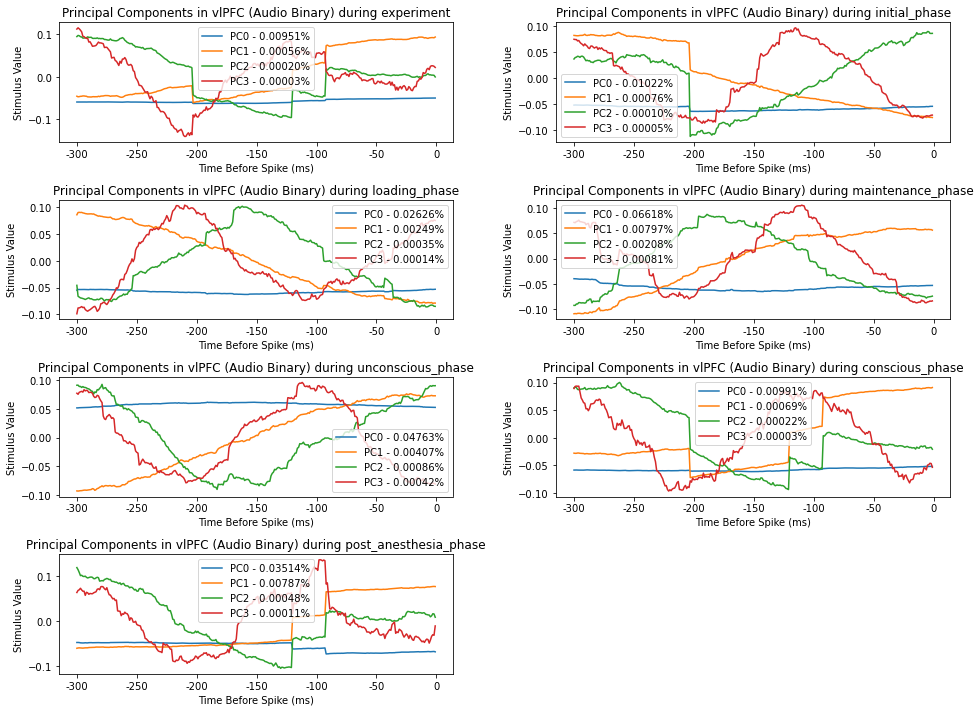

In [470]:
area = 'vlPFC'
n_components = 4
pca = sklearn.decomposition.PCA(n_components=n_components)
plt.figure(figsize=(14, 10))

for k, phase in enumerate(area_sta_mats[area].keys()):
    X = area_sta_mats[area][phase].T
    pca_fit = pca.fit(X)
    
    plt.subplot(4, 2, k+1)
    for i in range(n_components):
        plt.plot(pca_fit.components_[i], label=f"PC{i} - {pca_fit.explained_variance_[i]:.5f}%")
        plt.xlabel('Time Before Spike (ms)')
        plt.xticks(np.arange(0, sta_length + 1, 50), np.arange(-sta_length, 1, 50))
        plt.ylabel('Stimulus Value')
        plt.title(f"Principal Components in {area} ({stimulus_name}) during {phase}")
    plt.legend()
plt.tight_layout()
plt.show()

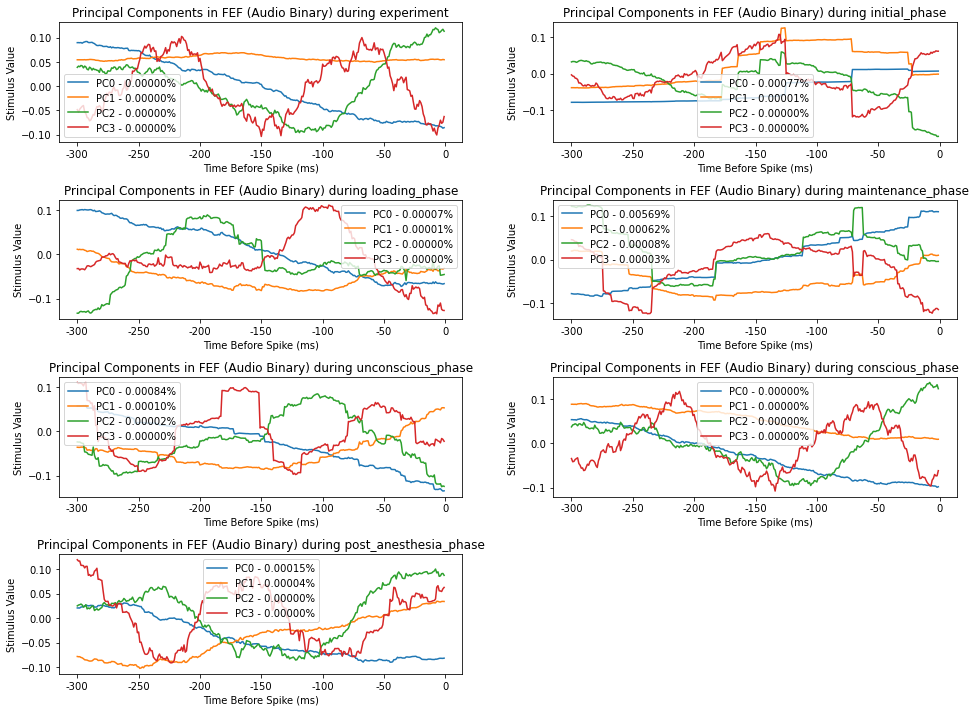

In [471]:
area = 'FEF'
n_components = 4
pca = sklearn.decomposition.PCA(n_components=n_components)
plt.figure(figsize=(14, 10))

for k, phase in enumerate(area_sta_mats[area].keys()):
    X = area_sta_mats[area][phase]
    X_ = (X - X.mean(1).reshape(sta_length, 1))
    pca_fit = pca.fit(X_ @ X_.T)
    pca_fit.components_.shape
    
    plt.subplot(4, 2, k+1)
    for i in range(n_components):
        plt.plot(pca_fit.components_[i], label=f"PC{i} - {pca_fit.explained_variance_[i]:.5f}%")
        plt.xlabel('Time Before Spike (ms)')
        plt.xticks(np.arange(0, len(stas[unit_index]['stas'][phase]['sta']) + 1, 50), np.arange(-len(stas[unit_index]['stas'][phase]['sta']), 1, 50))
        plt.ylabel('Stimulus Value')
        plt.title(f"Principal Components in {area} ({stimulus_name}) during {phase}")
    plt.legend()
plt.tight_layout()
plt.show()

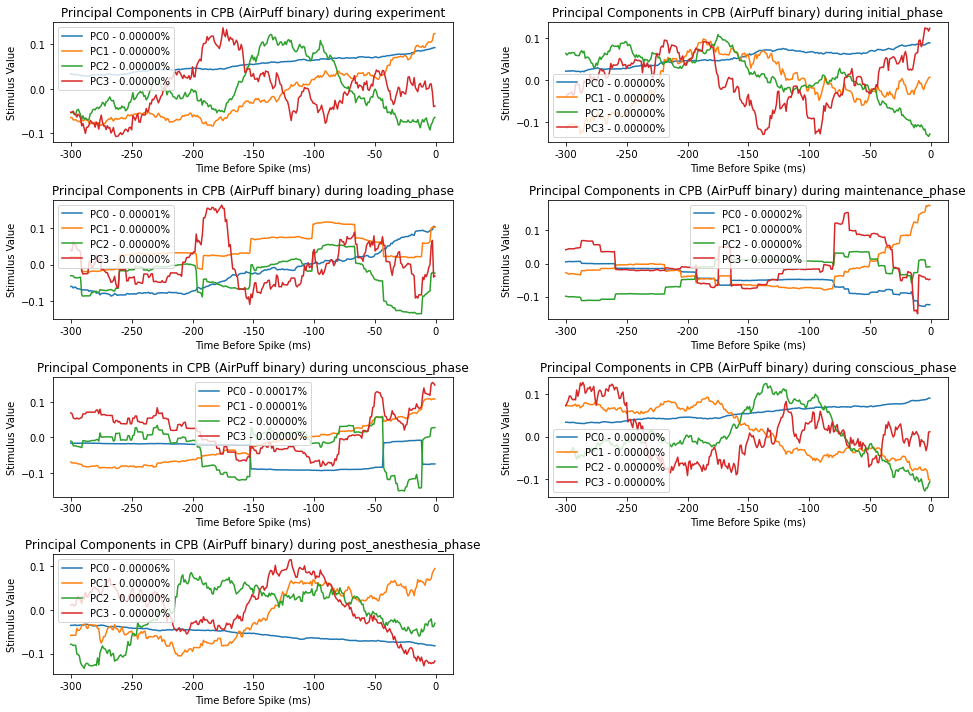

In [458]:
area = 'CPB'
n_components = 4
pca = sklearn.decomposition.PCA(n_components=n_components)
plt.figure(figsize=(14, 10))

for k, phase in enumerate(area_sta_mats[area].keys()):
    X = area_sta_mats[area][phase]
    X_ = (X - X.mean(1).reshape(sta_length, 1))
    pca_fit = pca.fit(X_ @ X_.T)
    pca_fit.components_.shape
    
    plt.subplot(4, 2, k+1)
    for i in range(n_components):
        plt.plot(pca_fit.components_[i], label=f"PC{i} - {pca_fit.explained_variance_[i]:.5f}%")
        plt.xlabel('Time Before Spike (ms)')
        plt.xticks(np.arange(0, len(stas[unit_index]['stas'][phase]['sta']) + 1, 50), np.arange(-len(stas[unit_index]['stas'][phase]['sta']), 1, 50))
        plt.ylabel('Stimulus Value')
        plt.title(f"Principal Components in {area} ({stimulus_name}) during {phase}")
    plt.legend()
plt.tight_layout()
plt.show()